<a href="https://colab.research.google.com/github/theonlyworld/DeepLearningWithPython/blob/main/DL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32")/255
test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype("float32")/255

In [ ]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.2645 - accuracy: 0.9243
Epoch 2/5
469/469 [==============================] - 3s 7ms/step - loss: 0.1087 - accuracy: 0.9687
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0699 - accuracy: 0.9792
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0505 - accuracy: 0.9851
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0383 - accuracy: 0.9883


In [ ]:
test_digits = test_images[0:10]
predictions = model.predict(test_digits)
predictions[0]

1/1 [==============================] - 0s 88ms/step


array([2.2069452e-08, 1.2422749e-08, 8.3504783e-06, 3.4554418e-05,
       7.4765763e-11, 3.1149807e-07, 2.8338073e-11, 9.9994928e-01,
       2.3177486e-07, 7.1183958e-06], dtype=float32)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")

313/313 [==============================] - 1s 1ms/step - loss: 0.0699 - accuracy: 0.9781
test_acc: 0.9781000018119812


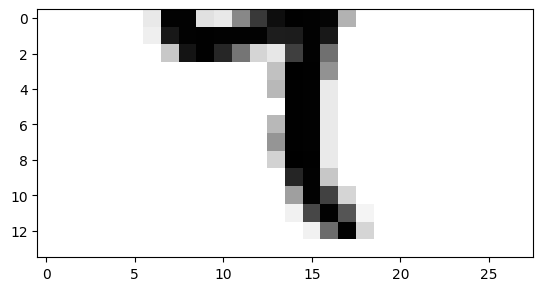

In [18]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

import matplotlib.pyplot as plt
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [ ]:
train_images[4]

## 使用NumPy进行张量计算
通过`train_images[i]`语句我们可以在第一个轴中选出一个特定的数字。这种在张量中挑选特定元素的行为也称作张量切片（tensor slicing）。
通过NumPy库我们可以进行切片操作，如挑选第10到100个（不包含第100个）元素，其形状是（90,28,28）


In [ ]:
my_slice = train_images[10:100]
my_slice.shape

(90, 28, 28)

下面的语句是等效的，它尤其在每一个轴中都明确了一个开始索引和结束索引。注意：号与选择该轴所有元素是相同的意思

In [ ]:
my_slice = train_images[10:100, :, :]   #与前例等同
my_slice.shape
my_slice = train_images[10:100, 0:28, 0:28] #同样与前例等同
my_slice.shape

(90, 28, 28)

你也可以在任一个轴中在两个索引中进行切片。例如，想在所有的图像中选择右下角14x14大小的区域，你可以这么做

In [ ]:
my_slice = train_images[:, 14:, 14:]

使用负索引也是支持的。原理与Python中的lists结构相似。如，要想裁切出图像中间部分14x14像素大小的区域，你可以这样做

In [ ]:
my_slice = train_images[:, 7:-7, 7:-7]

## 数据批次的概念
在深度学习中所有数据张量中的第一个轴就是样本轴（samples axis），通常也称作样本维度（samples dimension）。以MNIST为例，样本就是数据的图像。
此外，深度学习不会一次性对整个数据集进行处理，而是将数据分解为小的批次。下面这个例子就是我们MNIST数据的一个批次，大小为128。

In [ ]:
batch = train_images[:128]
batch = train_images[128:256]   #下一个批次
n = 3   #第n个批次
batch = train_images[128*n:128*(n+1)]

考虑到批次张量这一概念，第一轴也称作批次轴（batch axis）或批次维度（batch dimension）。

## 真实世界的例子
所有数据都可以分为以下几类：
- 向量 rank-2张量（样本，特征），每个样本都是一个数值属性的向量（特征）
- 时间序列或者序列数据 rank-3张量（样本，时间步长，特征），每一个样本都是一个特征向量的序列（时间步长的长度）
- 图像 rank-4张量（样本，高度，宽度，通道），每个样本都是2d的像素格，每个像素都代表一个通道数的向量
- 视频 rank-5张量（样本，帧，高度，宽度，通道），每个样本都是图像的一个序列（帧的长度）

## 向量数据
该数据集中，每个数据点可以编码成一个向量，那么一个数据的批次就会被编码为一个rank-2大小的张量（即一批向量），第一轴即样本轴，第二轴即特征轴。

## 时间序列数据或序列数据
当你的数据需要考虑时间因素时（或者顺序），那么通过加入时间轴将数据保存为rank-3形式就是必要的。每个样本可以编码为一个向量的序列（rank-2张量），那么一个批次就是一个rank-3张量。习惯上，时间轴通常是第二轴。

## 图像